In [ ]:
!python -c "import torch; print(torch.version.cuda)"

# Install Pytorch Geometric
# !pip install -q torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.9.0.html
# !pip install -q torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.9.0.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git

11.8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from torch_geometric.datasets import EllipticBitcoinDataset
from torch_geometric.transforms import NormalizeFeatures

In [ ]:
dataset = EllipticBitcoinDataset(root='data/EllipticBitcoinDataset', transform=NormalizeFeatures())
print(dataset)

Extracting data/EllipticBitcoinDataset/raw/elliptic_txs_features.csv.zip
Extracting data/EllipticBitcoinDataset/raw/elliptic_txs_edgelist.csv.zip
Extracting data/EllipticBitcoinDataset/raw/elliptic_txs_classes.csv.zip
Processing...


EllipticBitcoinDataset()


Done!


In [ ]:
dataset[0].edge_index

tensor([[     0,      2,      4,  ..., 201921, 201480, 201954],
        [     1,      3,      5,  ..., 202042, 201368, 201756]])

In [ ]:
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


Number of graphs: 1
Number of features: 165
Number of classes: 2


In [ ]:
import pandas as pd
df_features = pd.read_csv('data/EllipticBitcoinDataset/raw/elliptic_txs_features.csv')
df_edges = pd.read_csv("data/EllipticBitcoinDataset/raw/elliptic_txs_edgelist.csv")
df_classes =  pd.read_csv("data/EllipticBitcoinDataset/raw/elliptic_txs_classes.csv")


<BarContainer object of 3 artists>

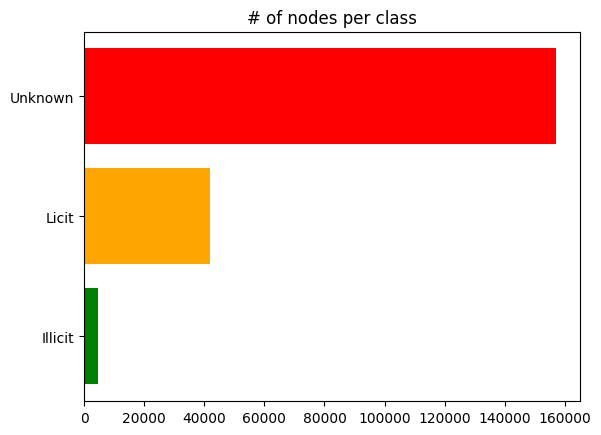

In [ ]:
import matplotlib.pyplot as plt
group_class = df_classes.groupby('class').count()
plt.title("# of nodes per class")
plt.barh([ 'Illicit','Licit', 'Unknown'], group_class['txId'].values, color=['g', 'orange', 'r'] )


In [ ]:
data = dataset[0]

print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[203769, 165], edge_index=[2, 234355], y=[203769], train_mask=[203769], test_mask=[203769])
Number of nodes: 203769
Number of edges: 234355
Number of training nodes: 29894
Training node label rate: 0.15
Is undirected: False


In [ ]:
print(data.y)
print(dataset[0].x.shape)

dataset.num_classes


tensor([2, 2, 2,  ..., 1, 2, 2])
torch.Size([203769, 165])


2

GNN using GCN

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv #GATConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        x = F.softmax(self.out(x), dim=1)
        return x

model = GCN(hidden_channels=128)
print(model)

**Training**

In [ ]:
# model = GCN(hidden_channels=16)

#GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)

learning_rate = 0.15
decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate,
                             weight_decay=decay)

criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc

losses = []
for epoch in range(0, 100):
    loss = train()
    losses.append(loss)
    if epoch % 10 == 0:
      print(f'Epoch: {epoch}, Loss: {loss:.4f}')

Epoch: 0, Loss: 0.6879
Epoch: 10, Loss: 0.4293
Epoch: 20, Loss: 0.4292
Epoch: 30, Loss: 0.4292
Epoch: 40, Loss: 0.4293
Epoch: 50, Loss: 0.4293
Epoch: 60, Loss: 0.4293
Epoch: 70, Loss: 0.4293
Epoch: 80, Loss: 0.4293
Epoch: 90, Loss: 0.4294


In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.9350


**GNN using GAT**

In [ ]:
data2=dataset[0]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

# ... (previous code for dataset loading and model definition)

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, num_heads):
        super(GAT, self).__init__()
        torch.manual_seed(42)

        self.conv1 = GATConv(dataset.num_features, hidden_channels, heads=num_heads)
        self.conv2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads)
        self.out = Linear(hidden_channels * num_heads, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.out(x)
        return x

num_heads = 4  #attention heads
model2 = GAT(hidden_channels=128, num_heads=num_heads)
print(model)



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model2 = model2.to(device)
data2 = data2.to(device)

learning_rate = 0.01
decay = 5e-4
optimizer = torch.optim.Adam(model2.parameters(),
                             lr=learning_rate,
                             weight_decay=decay)

criterion = torch.nn.CrossEntropyLoss()

def train():
      model2.train()
      optimizer.zero_grad()
      out = model2(data2.x, data2.edge_index)
      loss = criterion(out[data2.train_mask], data2.y[data2.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test2():
      model2.eval()
      out = model2(data2.x, data2.edge_index)
      pred = out.argmax(dim=1)
      test_correct = pred[data2.test_mask] == data2.y[data2.test_mask]
      test_acc = int(test_correct.sum()) / int(data2.test_mask.sum())
      return test_acc

losses = []
for epoch in range(0, 100):
    loss = train()
    losses.append(loss)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')


In [ ]:
pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/IMDB'
dataset = IMDB(path)
data = dataset[0]

data2 = sio.loadmat(f'/content/drive/MyDrive/IMDB/IMDB.mat')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import copy
import os.path as osp
import random

import numpy as np
import scipy.io as sio
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from torch_geometric.data import HeteroData
from torch_geometric.datasets import IMDB
from torch_geometric.nn import Linear, HGTConv

path = '/content/drive/MyDrive/IMDB'
dataset = IMDB(path)
data = dataset[0]

data2 = sio.loadmat(f'/content/drive/MyDrive/IMDB/IMDB.mat')
node_types = ['movie', 'actor']
data1 = HeteroData()
data1['movie'].x = torch.FloatTensor(data2['X1'])
data1['actor'].x = torch.FloatTensor(data2['X2'])
for i in range(data2['edge_index'].shape[1]):
    data2['edge_index'][1, i] -= data['movie']['x'].shape[0]
data1[('movie', 'to', 'actor')].edge_index = torch.LongTensor(data2['edge_index'])
arr = np.copy(data2['edge_index'])
arr[[0, 1], :] = arr[[1, 0], :]
data1[('actor', 'to', 'movie')].edge_index = torch.LongTensor(arr)
gnd = data2['label'][0, :]
gnd1 = gnd[0:data['movie']['x'].shape[0]]
gnd2 = gnd[data['movie']['x'].shape[0]:]
a = np.sum(gnd)
X = dict()
for node_type in node_types:
    X[node_type] = data1[node_type].x
T = dict()
T['movie'] = torch.zeros((data['movie']['x'].shape[0], 2))
T['actor'] = torch.zeros((data['actor']['x'].shape[0], 2))
for i in range(data['movie']['x'].shape[0]):
    T['movie'][i, 0] = 1
for i in range(data['actor']['x'].shape[0]):
    T['actor'][i, 1] = 1

A = dict()
flag_movie = []
for i in range(data.x_dict['movie'].shape[1]):
    flag_movie.append(random.randint(1, 2))
flag_movie = np.array(flag_movie)
flag_actor = []
for i in range(data.x_dict['actor'].shape[1]):
    flag_actor.append(random.randint(1, 3))
flag_actor = np.array(flag_actor)
n = 0
m = 0
X_views = dict()
X_views['movie'] = []
X_views['actor'] = []
index_movie = []
index_actor = []
for i in range(2):
    while n < len(flag_movie):
        if flag_movie[n] == i + 1:
            index_movie.append(n)
        n += 1
    X_views['movie'].append(X['movie'][:, index_movie])
    index_movie = []
    n = 0
for i in range(3):
    while m < len(flag_actor):
        if flag_actor[m] == i + 1:
            index_actor.append(m)
        m += 1
    X_views['actor'].append(X['actor'][:, index_actor])
    index_actor = []
    m = 0
y_dict1 = dict.copy(data.x_dict)
y_dict1['movie'] = X_views['movie'][0]
y_dict1['actor'] = X_views['actor'][0]
y_dict2 = dict.copy(data.x_dict)
y_dict2['movie'] = X_views['movie'][1]
y_dict2['actor'] = X_views['actor'][0]
y_dict3 = dict.copy(data.x_dict)
y_dict3['movie'] = X_views['movie'][0]
y_dict3['actor'] = X_views['actor'][1]
y_dict4 = dict.copy(data.x_dict)
y_dict4['movie'] = X_views['movie'][1]
y_dict4['actor'] = X_views['actor'][1]
y_dict5 = dict.copy(data.x_dict)
y_dict5['movie'] = X_views['movie'][0]
y_dict5['actor'] = X_views['actor'][2]
y_dict6 = dict.copy(data.x_dict)
y_dict6['movie'] = X_views['movie'][1]
y_dict6['actor'] = X_views['actor'][2]
list1 = [y_dict1, y_dict2, y_dict3, y_dict4, y_dict5, y_dict6]
for edge_type in data.edge_index_dict.keys():
    A[edge_type] = torch.sparse.FloatTensor(data.edge_index_dict[edge_type],
                                            torch.LongTensor(np.ones(data.edge_index_dict[edge_type].shape[1])),
                                            torch.Size([data[edge_type[0]]['x'].shape[0],
                                                        data[edge_type[2]]['x'].shape[0]])).to_dense()


class HGT(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_heads, num_layers, num_view):
        super().__init__()
        self.weight = torch.nn.Parameter(torch.randn(num_view), requires_grad=True)
        self.weight_node_type = torch.nn.Parameter(torch.randn(2), requires_grad=True)
        self.lin_dict = torch.nn.ModuleDict()
        for node_type in data.node_types:
            self.lin_dict[node_type] = torch.nn.ModuleList()
            for i in range(6):
                if i == 0:
                    self.lin_dict[node_type].append(Linear(y_dict1[node_type].shape[1], hidden_channels))
                if i == 1:
                    self.lin_dict[node_type].append(Linear(y_dict2[node_type].shape[1], hidden_channels))
                if i == 2:
                    self.lin_dict[node_type].append(Linear(y_dict3[node_type].shape[1], hidden_channels))
                if i == 3:
                    self.lin_dict[node_type].append(Linear(y_dict4[node_type].shape[1], hidden_channels))
                if i == 4:
                    self.lin_dict[node_type].append(Linear(y_dict5[node_type].shape[1], hidden_channels))
                if i == 5:
                    self.lin_dict[node_type].append(Linear(y_dict6[node_type].shape[1], hidden_channels))
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HGTConv(hidden_channels, hidden_channels, data.metadata(), num_heads, group='sum')
            self.convs.append(conv)

        self.out_dict = torch.nn.ModuleDict()
        for node_type in data.node_types:
            self.out_dict[node_type] = Linear(hidden_channels, out_channels)
        self.lin = torch.nn.ModuleDict()
        for node_type in data.node_types:
            self.lin[node_type] = Linear(out_channels, data.x_dict[node_type].shape[1])
        self.Tlin = torch.nn.ModuleDict()
        for node_type in data.node_types:
            self.Tlin[node_type] = Linear(out_channels, 2)

    def forward(self, x_dict, edge_index_dict):
        list3 = dict()
        for node_type, _ in x_dict[0].items():
            list3[node_type] = []
        for i in range(6):
            for node_type, x in x_dict[i].items():
                x_dict[i][node_type] = self.lin_dict[node_type][i](x).relu_()

            for conv in self.convs:
                x_dict[i] = conv(x_dict[i], edge_index_dict)

            for node_type, _ in x_dict[0].items():
                list3[node_type].append(self.out_dict[node_type](x_dict[i][node_type]))

        weight_norm = F.softmax(self.weight, dim=0)
        weight_type = F.softmax(self.weight_node_type, dim=0)
        Z_dict = dict()
        A_head = dict()
        X_head = dict()
        t_head = dict()
        T_head = dict()
        for node_type, _ in x_dict[0].items():
            Z_dict[node_type] = weight_norm[0] * list3[node_type][0] + weight_norm[1] * list3[node_type][1] + \
                                weight_norm[2] * list3[node_type][2] + weight_norm[3] * list3[node_type][3] + \
                                weight_norm[4] * list3[node_type][4] + weight_norm[5] * list3[node_type][5]
            X_head[node_type] = self.lin[node_type](Z_dict[node_type])
            t_head[node_type] = self.Tlin[node_type](Z_dict[node_type])
            T_head[node_type] = torch.zeros((t_head[node_type].shape[0], t_head[node_type].shape[1]))
            for i in range(T_head[node_type].shape[0]):
                T_head[node_type][i, 0] = weight_type[0] * t_head[node_type][i, 0]
                T_head[node_type][i, 1] = weight_type[1] * t_head[node_type][i, 1]
            T_head[node_type] = F.softmax(T_head[node_type], dim=0)
        for edge_type in edge_index_dict.keys():
            A_head[edge_type] = torch.sigmoid(torch.mm(Z_dict[edge_type[0]], Z_dict[edge_type[2]].T))

        return A_head, X_head, T_head, weight_norm, weight_type
model = HGT(hidden_channels=64, out_channels=16, num_heads=2, num_layers=2, num_view=6)
device = torch.device('cpu')
data, model = data.to(device), model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.00001)


def multiview(x, num1, num2):
    X_hat_views = dict()
    X_hat_views['movie'] = []
    X_hat_views['actor'] = []
    index_movie = []
    index_actor = []
    n = 0
    m = 0
    for i in range(num1):
        while n < len(flag_movie):
            if flag_movie[n] == i + 1:
                index_movie.append(n)
            n += 1
        X_hat_views['movie'].append(x['movie'][:, index_movie])
        index_movie = []
        n = 0
    for i in range(num2):
        while m < len(flag_actor):
            if flag_actor[m] == i + 1:
                index_actor.append(m)
            m += 1
        X_hat_views['actor'].append(x['actor'][:, index_actor])
        index_actor = []
        m = 0
    return X_hat_views


def train():
    model.train()
    optimizer.zero_grad()
    input_list = copy.deepcopy(list1)
    A_hat, X_hat, T_hat, wX, wT = model(input_list, data.edge_index_dict)
    loss = 0
    loss += torch.norm(A_hat[('movie', 'to', 'actor')] - A[('movie', 'to', 'actor')])
    loss += torch.norm(A_hat[('actor', 'to', 'movie')] - A[('actor', 'to', 'movie')])
    for node_type in node_types:
        loss += pow(torch.norm(T_hat[node_type] - T[node_type]), 2)
    loss += torch.norm(X_hat['movie'] - X['movie'])
    loss += torch.norm(X_hat['actor'] - X['actor'])
    loss=loss/float(gnd.shape[0])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    input_list = copy.deepcopy(list1)
    out = model(input_list, data.edge_index_dict)
    ano_score = []
    for i in range(data['movie']['x'].shape[0]):
        ano_score.append(0.47 * torch.norm(out[0][('movie', 'to', 'actor')][i] - A[('movie', 'to', 'actor')][i])
        + 0.47 * torch.norm(out[1]['movie'][i] - X['movie'][i])+0.06 * torch.norm(out[2]['movie'][i] - torch.FloatTensor(np.array(T['movie']))))

    for i in range(data['actor']['x'].shape[0]):
        ano_score.append(0.47 * torch.norm(out[0][('actor', 'to', 'movie')][i] - A[('actor', 'to', 'movie')][i])
        + 0.47 * torch.norm(out[1]['actor'][i] - X['actor'][i])+0.06 * torch.norm(out[2]['actor'][i] - torch.FloatTensor(np.array(T['actor']))))

    auc = roc_auc_score(gnd, np.array(ano_score) / max(ano_score))

    return auc

best_auc=0
for epoch in range(1, 101):
    loss = train()
    auc = test()

    if auc>best_auc:
        best_auc=auc
    print(
    f'Epoch: {epoch:03d}, Loss: {loss:.4f}, AUC:{auc:.4f}')
print(best_auc)

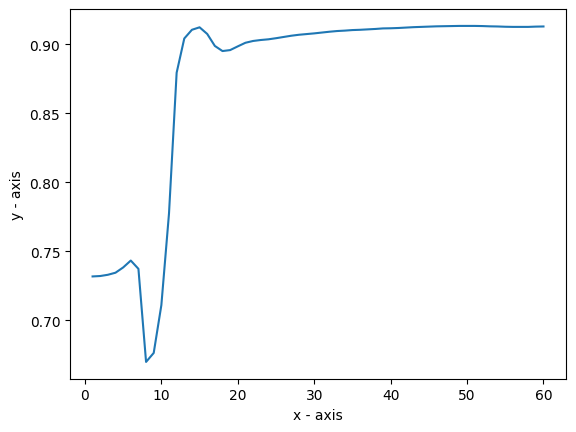

In [ ]:
import matplotlib.pyplot as plt

# x axis values
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60]
# corresponding y axis values
y = [0.7318,
0.7321,
0.7330,
0.7345,0.7383, 0.7433, 0.7373, 0.6699, 0.6764, 0.7110, 0.7774, 0.8793, 0.9041, 0.9104, 0.9122, 0.9074, 0.8987, 0.8950, 0.8957, 0.8984, 0.9010, 0.9023, 0.9030, 0.9035, 0.9043, 0.9052, 0.9061, 0.9068, 0.9073, 0.9078, 0.9084, 0.9090, 0.9095, 0.9098, 0.9102, 0.9104, 0.9107, 0.9110, 0.9114, 0.9115, 0.9117, 0.9120, 0.9123, 0.9125, 0.9127, 0.9129, 0.9130, 0.9131, 0.9132, 0.9132, 0.9132, 0.9131, 0.9129, 0.9128, 0.9126, 0.9125, 0.9125, 0.9125, 0.9127, 0.9128]

# plotting the points
plt.plot(x, y)

# naming the x axis
plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')

# giving a title to my graph

# function to show the plot
plt.show()

### GAN

In [ ]:
!pip install torch-geometric

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

class Generator(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels):
        super().__init__()
        self.lin1 = nn.Linear(in_channels, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, hidden_channels)
        self.lin3 = nn.Linear(hidden_channels, out_channels)

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.lin1 = nn.Linear(in_channels, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, hidden_channels)
        self.lin3 = nn.Linear(hidden_channels, 1)

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x

# class GNNExplainer:
#     def __init__(self, generator, discriminator, device):
#         self.generator = generator
#         self.discriminator = discriminator
#         self.device = device

#     def train(self, data, epochs, batch_size, learning_rate):
#         optimizer_G = torch.optim.Adam(self.generator.parameters(), lr=learning_rate)
#         optimizer_D = torch.optim.Adam(self.discriminator.parameters(), lr=learning_rate)

#         for epoch in range(epochs):
#             for i in range(0, len(data), batch_size):
#                 batch = data[i:i+batch_size]

#                 # Real explanations
#                 real_explanations = []
#                 for graph in batch:
#                     anomaly_node = pyg_utils.get_random_node(graph.num_nodes)
#                     removed_edges = pyg_utils.remove_edges(graph, anomaly_node)
#                     real_explanations.append(removed_edges)

#                 # Fake explanations
#                 fake_explanations = self.generator(batch.x.to(self.device))

#                 # Train discriminator
#                 real_discrimination = self.discriminator(real_explanations.to(self.device))
#                 fake_discrimination = self.discriminator(fake_explanations.to(self.device))
#                 loss_D = -torch.mean(torch.log(real_discrimination + 1e-8) + torch.log(1 - fake_discrimination + 1e-8))

#                 optimizer_D.zero_grad()
#                 loss_D.backward()
#                 optimizer_D.step()

#                 # Train generator
#                 fake_discrimination = self.discriminator(fake_explanations.to(self.device))
#                 loss_G = -torch.mean(torch.log(fake_discrimination + 1e-8))

#                 optimizer_G.zero_grad()
#                 loss_G.backward()
#                 optimizer_G.step()

#                 if (i + batch_size) % 100 == 0:
#                     print(f"Epoch {epoch}/{epochs} | Batch {i}/{len(data)} | Loss D: {loss_D.item():.4f} | Loss G: {loss_G.item():.4f}")

#     def generate_explanations(self, data):
#         explanations = []
#         for graph in data:
#             explanation = self.generator(graph.x.to(self.device)).squeeze(0)
#             explanations.append(explanation)

#         return explanations


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

# Load the Cora dataset using PyTorch Geometric
dataset = Planetoid(root='data', name='Cora')
data = dataset[0]


# Extract node labels from the data object
node_labels = data.y

# Calculate label counts
label_counts = torch.bincount(node_labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Determine the target class as the label with the highest frequency
target_class = label_counts.argmax()
def remove_edges(edge_index, anomaly_node, device):
    anomaly_node = torch.full((edge_index.size(1),), int(anomaly_node), dtype=torch.long, device=device)

    edge_index = edge_index.to(device='cpu')

    mask = (edge_index[0] != anomaly_node) & (edge_index[1] != anomaly_node)

    mask = mask.to(device)

    # Filter out edges using the mask
    filtered_edge_index = edge_index[:, mask]

    return filtered_edge_index



# Define graph construction function
def construct_graph(edge_index, num_nodes):
    # Create a PyTorch Geometric data object
    graph = data.clone()
    graph.edge_index = edge_index
    return graph

# Preprocess the data
def preprocess_data(idx):
    # Ensure that both the graph and node features are on the same device

    # Extract edge information from the data object
    edge_index = data.edge_index

    # Create a PyTorch Geometric data object from the edge information
    graph = construct_graph(edge_index, num_nodes=data.num_nodes)

    # Label graph as normal or anomalous
    label = 1 if data.y[idx] == target_class else 0  # Use target_class instead of data.target_class

    if label == 1:
        # Generate real explanation by removing edges
        anomaly_node = torch.randint(graph.num_nodes, (1,))

        anomaly_node = anomaly_node.to(device)  # Move anomaly_node to the CUDA device
        removed_edges = remove_edges(graph.edge_index, anomaly_node, device)
        real_explanations.append(removed_edges)

        # Construct modified graph
        modified_edge_index = modify_edge_information(edge_index)
        modified_graph = construct_graph(modified_edge_index, num_nodes=data.num_nodes).to(device)

        return None, modified_graph, label

    return None, graph, label
# Define a function to modify the edge information for the modified graph
def modify_edge_information(edge_index):
    # Implement your logic to modify the edge information here
    # This is a placeholder, you need to customize it based on your requirements
    modified_edge_index = edge_index.clone()
    return modified_edge_index

# Prepare data for training
real_explanations = []
fake_explanations = []

for i in range(data.num_edges):
    features, graph, label = preprocess_data(i)

    if label == 1:
        # Generate real explanation by removing edges
        anomaly_node = torch.randint(graph.num_nodes, (1,)).item()

        removed_edges = remove_edges(graph.edge_index, anomaly_node,device)
        real_explanations.append(removed_edges)

        # Generate fake explanation using the GAN
        fake_explanation = generator(graph.ndata['feat'].to(device)).squeeze(0)
        fake_explanations.append(fake_explanation)


# Train the GAN explainer
generator = Generator(in_channels=features.shape[0], out_channels=data.num_nodes * data.num_nodes)
discriminator = Discriminator(in_channels=data.num_nodes * data.num_nodes, hidden_channels=128)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gnn_explainer = GNNExplainer(generator, discriminator, device)
gnn_explainer.train(data=processed_data, epochs=10, batch_size=32, learning_rate=0.001)

# Generate explanations for new data points
new_features, new_graph, new_label = preprocess_data(100)  # Replace 100 with the index of the new data point
new_explanation = gnn_explainer.generate_explanations([new_graph])[0]

# Evaluate the explanation
# ...  # Replace ... with your explanation evaluation code


In [ ]:
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='data', name='Cora')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[0]
print(len(data))

6


In [ ]:
class GNNExplainer:
    def __init__(self, generator, discriminator, device):
        self.generator = generator
        self.discriminator = discriminator
        self.device = device

    def train(self, data, epochs, batch_size, learning_rate):
        optimizer_G = torch.optim.Adam(self.generator.parameters(), lr=learning_rate)
        optimizer_D = torch.optim.Adam(self.discriminator.parameters(), lr=learning_rate)

        for epoch in range(1):
            for i in range(0, 1, batch_size):
                batch = data[i:i+batch_size]

                # Real explanations
                real_explanations = []
                for graph in batch:
                    anomaly_node = torch.randint(graph.num_nodes, (1,)).item()
                    # Assuming graph has 'edge_index' attribute
                    mask = (graph.edge_index[0] != anomaly_node) & (graph.edge_index[1] != anomaly_node)
                    removed_edges = graph.edge_index[:, mask]
                    real_explanations.append(removed_edges)

                # Fake explanations
                fake_explanations = self.generator(batch.x.to(self.device))

                # Train discriminator
                real_discrimination = self.discriminator(real_explanations.to(self.device))
                fake_discrimination = self.discriminator(fake_explanations.to(self.device))
                loss_D = -torch.mean(torch.log(real_discrimination + 1e-8) + torch.log(1 - fake_discrimination + 1e-8))

                optimizer_D.zero_grad()
                loss_D.backward()
                optimizer_D.step()

                # Train generator
                fake_discrimination = self.discriminator(fake_explanations.to(self.device))
                loss_G = -torch.mean(torch.log(fake_discrimination + 1e-8))

                optimizer_G.zero_grad()
                loss_G.backward()
                optimizer_G.step()


                print(f"Epoch {epoch}/{epochs} | Batch {i}/{len(data)} | Loss D: {loss_D.item():.4f} | Loss G: {loss_G.item():.4f}")

    def generate_explanations(self, data):
        explanations = []

        for batch in data_loader:
            batch = batch.to(self.device)

            # Fake explanations
            fake_explanations = self.generator(batch.x)

            fake_explanations = fake_explanations.to_sparse()

            # Train discriminator
            real_discrimination = self.discriminator(batch.edge_index)
            fake_discrimination = self.discriminator(fake_explanations.indices())

            anomaly_scores = torch.sigmoid(fake_discrimination)

            threshold = 0.5  # Adjust this threshold based on your needs
            anomaly_indices = (anomaly_scores > threshold).nonzero()

            # Extract explanations based on anomaly indices
            for idx in anomaly_indices:
                anomaly_node = fake_explanations.indices()[idx]
                removed_edges = pyg_utils.remove_edges(batch.edge_index, anomaly_node)
                explanations.append(removed_edges)

        return explanations

# Initialize generator and discriminator
generator = Generator(in_channels=data.num_features, out_channels=data.num_nodes, hidden_channels=16)
discriminator = Discriminator(in_channels=data.num_nodes, hidden_channels=16)

# Initialize GNNExplainer
gnn_explainer = GNNExplainer(generator, discriminator, device)

# Training loop (call train method)
gnn_explainer.train(dataset, epochs=10, batch_size=32, learning_rate=0.001)

# Generate explanations for the entire dataset
# explanations = gnn_explainer.generate_explanations(data_loader)



In [ ]:
#DONT RUN

# Load the Cora dataset using PyTorch Geometric
# dataset = Planetoid(root='data', name='Cora')
# data = dataset[0]

# Extract node labels from the data object
node_labels = data.y

# Calculate label counts
label_counts = torch.bincount(node_labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Determine the target class as the label with the highest frequency
target_class = label_counts.argmax()

def remove_edges(edge_index, anomaly_node, device):
    # Ensure anomaly_node has the same shape as edge_index
    anomaly_node = torch.full((edge_index.size(1),), int(anomaly_node), dtype=torch.long, device=device)

    # Move edge_index to the CPU for element-wise comparisons
    edge_index = edge_index.to(device)

    # Create a mask to identify edges involving the anomaly node
    mask = (edge_index[0] != anomaly_node) & (edge_index[1] != anomaly_node)

    # Move the mask back to the CUDA device for subsequent operations
    mask = mask.to(device)

    # Filter out edges using the mask
    filtered_edge_index = edge_index[:, mask]

    return filtered_edge_index

# Define graph construction function
def construct_graph(edge_index, num_nodes):
    # Create a PyTorch Geometric data object
    graph = data.clone()
    graph.edge_index = edge_index
    return graph

# Preprocess the data
def preprocess_data(idx):
    # Ensure that both the graph and node features are on the same device

    # Extract edge information from the data object
    edge_index = data.edge_index

    # Create a PyTorch Geometric data object from the edge information
    graph = construct_graph(edge_index, num_nodes=data.num_nodes)

    # Label graph as normal or anomalous
    label = 1 if data.y[idx] == target_class else 0  # Use target_class instead of data.target_class

    if label == 1:
        # Generate real explanation by removing edges
        anomaly_node = torch.randint(graph.num_nodes, (1,))

        anomaly_node = anomaly_node.to(device)  # Move anomaly_node to the CUDA device
        removed_edges = remove_edges(graph.edge_index, anomaly_node, device)
        real_explanations.append(removed_edges)

        # Construct modified graph
        modified_edge_index = modify_edge_information(edge_index)
        modified_graph = construct_graph(modified_edge_index, num_nodes=data.num_nodes).to(device)

        return None, modified_graph, label

    return None, graph, label
# Define a function to modify the edge information for the modified graph
def modify_edge_information(edge_index):
    # Implement your logic to modify the edge information here
    # This is a placeholder, you need to customize it based on your requirements
    modified_edge_index = edge_index.clone()
    return modified_edge_index


# Initialize generator and discriminator
generator = Generator(in_channels=data.num_features, out_channels=data.num_nodes * data.num_nodes, hidden_channels=64)
discriminator = Discriminator(in_channels=data.num_nodes * data.num_nodes,hidden_channels=128)  # Fix: Use hidden_channels instead of in_channels

# Initialize GNNExplainer
gnn_explainer = GNNExplainer(generator, discriminator, device)

# Prepare data for training (replace processed_data with your actual training data)
real_explanations = []
fake_explanations = []

for i in range(data.num_edges):
    features, graph, label = preprocess_data(i)

    if label == 1:
        # Generate real explanation by removing edges
        anomaly_node = torch.randint(graph.num_nodes, (1,)).item()

        removed_edges = remove_edges(graph.edge_index, anomaly_node, device)
        real_explanations.append(removed_edges)

        # Generate fake explanation using the GAN
        fake_explanation = generator(data['x'].to(device)).squeeze(0)
        fake_explanations.append(fake_explanation)

# Train the GAN explainer
gnn_explainer.train(data=processed_data, epochs=10, batch_size=32, learning_rate=0.001)

# Generate explanations for new data points
new_features, new_graph, new_label = preprocess_data(100)  # Replace 100 with the index of the new data point
new_explanation = gnn_explainer.generate_explanations([new_graph])[0]


In [ ]:
from torch.utils.data import DataLoader
import torch_geometric

In [ ]:
dataset = Planetoid(root='data', name='Cora')
from torch_geometric.data import Data
from torch.utils.data import DataLoader

# Custom collate function
def collate(data_list):
    batch = Data()

    # Extract necessary information from Data objects
    batch.x = [data.x for data in data_list]
    batch.edge_index = [data.edge_index for data in data_list]

    return batch

# Create DataLoader with custom collate function
data_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create instances of Generator and Discriminator
generator = Generator(in_channels=data.num_features, out_channels=data.num_nodes * data.num_nodes, hidden_channels=64)
discriminator = Discriminator(in_channels=data.num_nodes * data.num_nodes,hidden_channels=128)  # Fix: Use hidden_channels instead of in_channels

# Create an instance of GNNExplainer
gnn_explainer = GNNExplainer(generator, discriminator, device)
